# Tutorial: Creating Recommender Systems Datasets in Scientific Fields


<ul>
    <li><a href="#1">1. Data retrieval and cleaning</a></li>
</ul>
   
<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#1.1">1.1.Import libraries</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#1.2">1.2. Retrieve CORD-19</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#1.3">1.3. Exploring the articles of the dataset</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#1.4">1.4. Selecting a sample of articles to build our scientific recommendation dataset</a></li>
</ul>

<ul>
   <li><a href="#2">2. Named Entity Recognition (NER) + Named Entity Linking (NEL)</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#2.1">2.1. Import libraries</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#2.2">2.2. Configure MER</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#2.3">2.3. Import stop words vocabulary and tokenizer</a></li>
</ul>


<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#2.4">2.4. Extract the entities in a single file</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#2.5">2.5. Create entity files</a></li>
</ul>

<ul>
   <li><a href="#3">3. Creating the recommendation dataset</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#3.1">3.1. Import libraries</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#3.2">3.2. Get all articles id that cannot be considered in use case: blacklist </a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#3.3">3.3. Create the dataset like < user, item, rating, year> </a></li>
</ul>


<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#3.4">3.4. Get entities labels</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#3.5">3.5. Save data</a></li>
</ul>

<ul>
   <li><a href="#4">4. Data statistics</a></li>
</ul>

















<a id="1"></a>

## 1. Data retrieval + cleaning

**Goal**: To retrieve the [COVID-19 Open Research Dataset (CORD-19)](https://www.semanticscholar.org/cord19) and to select a sample of complete English articles (authors' info, title, body text) to build a scientific recommendation dataset.

CORD-19 includes coronavirus-related research articles extracted from several sources, such as PubMed, bioRxiv, medRxiv, WHO.

<a id="1.1"></a>
### 1.1 Import libraries

In [2]:
import json
import os
import pandas as pd
import requests
import sys
import langdetect
from langdetect import detect
sys.path.append("./")

<a id="1.2"></a>
### 1.2. Retrieve CORD-19

CORD-19 is a large dataset, so in this tutorial we are going to use a smaller version of the dataset. 
This version is located under the directory "cord19_small":

In [ ]:
os.chdir('data')
os.system('tar -xvf cord19_small.tar.xz')
os.chdir('../')

However, if you want to retrieve the entire dataset, you can run the following code:

In [ ]:
os.chdir('data')
         
version = 'cord-19_2020-05-12.tar.gz'

url = 'https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases/' + version

response = requests.get(url)

os.system('tar -xvf cord-19_2020-05-12.tar.gz')
os.chdir('../')

Let's explore the contents of the dataset directory, particularly, the metadata file.

In [ ]:
dataset_dir = 'data/cord19_small/'
metadata_filepath = dataset_dir + 'metadata.csv'

metadata = pd.read_csv(metadata_filepath, sep = ',', quotechar = '"',  encoding = 'utf-8', dtype=str) 

Now we have a DataFrame with the contents of the metadata file.

To print column names and first row:

In [ ]:
metadata.head(1)

To access individual rows/articles:

In [ ]:
metadata.loc[0]

To access the individual column title':

In [ ]:
metadata['title']

Let's check the summary statistics:

In [ ]:
metadata.count()

By looking at the statistics, we can see that the number of records with data for the column 'cord_uid' is higher than the number of records with data for the column 'authors'. 

For our dataset, we only want to include articles with the following characteristics:
- authors' information
- available title
- available body text
- article text expressed in English
- non-duplicate articles

<a id="1.3"></a>

### 1.3. Exploring the articles of the dataset

Let's consider the first article appearing in the metadata file.
To check if information about the article's author is available:

In [ ]:
metadata.loc[0]['authors']

To check if there is an available title:

In [ ]:
metadata.loc[0]['title']

We can see that the title is expressed in English, but it would not be efficient to check the language of every article in the dataset, so we will apply the language detection tool [langdetect](https://pypi.org/project/langdetect/):

In [ ]:
title1 = metadata.loc[0]['title']

title1_lang = detect(title1)

print("Title:", title1, "\nLanguage:", title1_lang)

The tool detects English as the language of the title.

Let's check another article:

In [ ]:
title2 = metadata.loc[199]['title']

title2_lang = detect(title2)

print("Title:", title2, "\nLanguage:", title2_lang)

In this case, the tool detects german ('de') as the language of the title.

Now, we want to check if there is an available abstract for the first article:

In [ ]:
metadata.loc[0]['abstract']

The metadata file does not contain the article's text besides abstract and title, but we can access the file associated with the article using the provided information in the columns 'pdf_json_files' or 'pmc_json_files':

In [ ]:
metadata.loc[0]['pdf_json_files']

Let's open the file, which is in [JSON](https://www.json.org/json-en.html) format:

In [ ]:
article1_filepath = dataset_dir + metadata.loc[0]['pdf_json_files']

with open(article1_filepath, encoding='utf-8') as article1_file:
    article1_data = json.load(article1_file)

Now we have the file content stored in a dictionary with the following keys:

In [ ]:
article1_data.keys()

The article content is the following:

In [ ]:
article1_data

Let's check the body text:

In [ ]:
body_text = article1_data['body_text']
body_text

We have a list of dictionaries, each dictionary is a paragraph belonging to a given section of the article. We want to join the different parts text in a single string: 

In [ ]:
article1_text = str()

for paragraph in body_text:
    article1_text += paragraph['text'] + '\n'

article1_text

All good! We will include this article in our dataset.

<a id="1.4"></a>

### 1.4. Selecting a sample of articles to build our scientific recommendation dataset

Instead of repating each operation for each file individually, let us adapt our code to automatically select a sample containing 100 preprocessed articles. 

First, create the output directory:

In [ ]:
out_dir = 'data/sample/'

if not os.path.exists(out_dir):
    os.mkdir(out_dir)

Then, initiallize the necessary variables:

In [ ]:
max_articles = 100 #number of articles to include in the sample
dataset_dir = 'data/cord19_small/'
metadata_filepath = dataset_dir + 'metadata.csv'
valid_articles_count = int()
out_articles_ids = list()

Open the metadata file:

In [ ]:
metadata = pd.read_csv(metadata_filepath, sep = ',', quotechar = '"',  encoding = 'utf-8', dtype=str) 

Then iterate over the records in the metadata file and choose only the relevant ones:

In [ ]:
valid_articles_count = int()
blacklist = str()
blacklist_count = int()

for index, record in metadata.iterrows():
    invalid_article = True
    
    if valid_articles_count <= max_articles:
        
        if record['pubmed_id'] not in out_articles_ids:
            
            if type(record['sha']) != float:

                if record['authors'] != '':    

                    if record['title'] != '':
                        title = record['title']
                        title_lang = detect(title)
                        article_filepath = record['pdf_json_files']
                        
                        if article_filepath != '': # to consider onyl articles from the pdf_json directory

                            if title_lang == 'en'  \
                                and type(article_filepath) != float  \
                                and article_filepath.count("document") == 1:

                                article_filepath_up = dataset_dir + record['pdf_json_files']

                                with open(article_filepath_up, encoding='utf-8') as article_file:
                                    article_data = json.load(article_file)

                                if 'body_text' in article_data.keys(): # the article is valid
                                    valid_articles_count += 1
                                    invalid_article = False

                                    # open the article file to check if it contains all info
                                    with open(article_filepath_up) as article_file:
                                        article_data = json.load(article_file)

                                    # correct the info of the article with info present in metadata file
                                    changed_article = False

                                    if article_data['metadata']['title'] == '':
                                        article_data['metadata']['title'] = record['title']
                                        changed_article = True

                                    if article_data['metadata']['authors'] == []:
                                        authors = record['authors'].split(';')   
                                        
                                        add_author = {
                                                     'first': '', 'middle': [], 'last': '',
                                                     'suffix': '', 'affiliation': {}, 'email': ''
                                                     }
                                        authors_up = list()            
                                        
                                        for author in authors:
                                            add_author['last'] = author.split(',')[0]
                                            
                                            begin_names = author.split(',')[1].split(' ')
                                            add_author['first'] = begin_names[1]
                                            
                                            if len(begin_names) == 3:
                                                add_author['middle'] = [begin_names[2]]
                                            
                                            authors_up.append(add_author)
                                            
                                        article_data['metadata']['authors'] = authors_up
                                        changed_article = True
                                        
                                    # output or copy article file to out_dir
                                    if changed_article:
                                      
                                        with open(out_dir + record['sha'] + '.json', 'w') as out_file:
                                            out_file.write(json.dumps(article_data, indent=4, ensure_ascii=False))

                                    else:
                                        command = 'cp '  \
                                                  + article_filepath_up + ' ' \
                                                  + out_dir  \
                                                  + record['sha'] + '.json'

                                        os.system(command)
        
        if invalid_article: # store article pubmed id in blacklist file
            blacklist += record['pubmed_id'] + "\n"
            blacklist_count += 1
            
    if valid_articles_count == max_articles:
        total_articles = index + 1
        break

#Create blacklist file with info about invalid articles
with open('data/blacklist/blacklist_articles.txt', 'w') as blacklist_file:
    blacklist_file.write(blacklist)
    blacklist_file.close()

print("Invalid articles:", str(blacklist_count))

If you were not able to run the code, you can uncompress the file 'sample.tar.xz' under 'data' directory.

Let's check if the output directory contain the desired number of articles (max_articles):

In [ ]:
article_count = len(os.listdir(out_dir))
assert article_count == max_articles, 'Invalid number of article(s): {}! Expected number: {}'.format(article_count, max_articles)

At the end of this section, we now have a sample including 100 articles that will be the basis of our scientific recommendation dataset.

<a id="2"></a>

## 2. Named Entity Recognition (NER) + Named Entity Linking (NEL)

**Goal**: To recognize chemical and disease entities in the retrieved articles and to link them to the respective ontology identifiers.

We are going to use the [Disease Ontology](https://disease-ontology.org/) (DO), and the [Chemical Entities of Biological Interest](https://www.ebi.ac.uk/chebi/) (ChEBI) ontology.

To perform NER and NEL, we are going to apply Minimal Named-Entity Recognizer [MER](https://pypi.org/project/merpy/) tool.

<a id="2.1"></a>
### 2.1. Import libraries

In [ ]:
import merpy
import multiprocessing
from collections import Counter

<a id="2.2"></a>
### 2.2. Configure MER

First, we are going to download the ontologies files:

Only for OSX
see: https://github.com/prisma-labs/python-graphql-client/issues/13

In [ ]:
import urllib.request
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
response = urllib.request.urlopen('https://www.python.org')

In [ ]:
os.chdir('data/ontologies')

#Donwload DO (2021-06-03 version)
os.system('wget https://raw.githubusercontent.com/DiseaseOntology/HumanDiseaseOntology/v2021-06-03/src/ontology/releases/doid.owl')
merpy.download_lexicon('https://raw.githubusercontent.com/DiseaseOntology/HumanDiseaseOntology/v2021-06-03/src/ontology/releases/doid.owl',
                       'doid', ltype='owl')

#Donwload ChEBI (2021-07-01 version)
os.system('wget ftp://ftp.ebi.ac.uk/pub/databases/chebi/archive/rel201/ontology/chebi_lite.owl.gz')
os.system ('gzip -d chebi_lite.owl.gz')
merpy.download_lexicon('ftp://ftp.ebi.ac.uk/pub/databases/chebi/archive/rel201/ontology/chebi_lite.owl',
                       'chebi', ltype='owl')

os.chdir('../../')

Then, we need to process the downloaded files into lexicons that MER can use:

In [ ]:
merpy.process_lexicon("doid", ltype="owl")

merpy.process_lexicon("chebi", ltype="owl")

We are going to delete obsolete concepts still present in the ontologies file:

In [ ]:
merpy.delete_obsolete("chebi")

merpy.delete_obsolete("doid")

We need to repeat the operations for the DO:

Let's check the lexicons available for MER:

In [ ]:
merpy.show_lexicons()

<a id="2.3"></a>
### 2.3. Import stop words vocabulary and tokenizer

Stop words are common words of a given language (for example the words 'the', 'and', 'in'). A typical pre-processing step is to tokenize the text and remove the stopwords. For that, we are going to import NLTK's list of english stopwords and use the NLTK tokenizer.

In [ ]:
import nltk 
nltk.download('punkt')

from nltk.corpus import stopwords

nltk.download('stopwords')

from nltk.tokenize import word_tokenize

all_stopwords = stopwords.words('english')

We are going to extend the stop words vocabulary by adding stop words associated with ChEBI and DO:

In [ ]:
kbs_stopwords = list()
blacklist_dir = 'data/blacklist/'
filenames = ['chebi.txt', 'doid.txt']

for filename in filenames:
    
    with open(blacklist_dir + filename, 'r') as backlist_file:
        stopwords = [content.strip('\n') for content in backlist_file.readlines()]
        kbs_stopwords.extend(stopwords)
        backlist_file.close()

#Extend stop words vocabulary with the retrieved KBs stopwords
all_stopwords.extend(kbs_stopwords)

<a id="2.4"></a>
### 2.4. Extract the entities in a single file

Let's retrieve a file from the articles sample:

In [ ]:
dataset_dir = 'data/sample/'

with open(dataset_dir + '87390d2ae28407b3e03e60a6b24a7fd99ed7229a.json') as article1_file:
    article_data = json.load(article1_file)

Let's check the contents of the article:

In [ ]:
article_data.keys()

We want to recognize the entities present in title, abstract, and body. 

First, let's retrieve the title, which is a value associated with the key 'metadata':

In [ ]:
title = article_data['metadata']['title']
title

Let's tokenize the title:

In [ ]:
title_tokens = word_tokenize(title)
title_tokens

And remove the tokens relative to stop words:

In [ ]:
title_tokens_up = [word for word in title_tokens if not word in all_stopwords]
title_tokens_up

And rebuild the title without the stop words:

In [ ]:
title_up = (' ').join(title_tokens_up)
title_up

Then, we apply MER to the preprocessed title in order to recognize disease entities and to link them to DO concepts:

In [ ]:
merpy.get_entities(title_up, 'doid')

Let's check if the annotations make sense. For instance, access the link http://purl.obolibrary.org/obo/DOID_2945.

The entity 'SARS' in the article was linked to the DO concept 'severe acute respiratory syndrome' with the identifier 'DOID:2945', which seems correct!

Let's apply MER to recognize chemical entities and to link them to ChEBI concepts:

In [ ]:
merpy.get_entities(title_up, 'chebi')

Accessing the link http://purl.obolibrary.org/obo/CHEBI_35341, we can see that the entity 'Steroids' was linked to the ChEBI concept 'steroid', which has the identifier 'CHEBI:35341'.

We add the disease and chemical entities to a single list:

In [ ]:
title_entities = merpy.get_entities(title_up, 'doid') + merpy.get_entities(title_up, 'chebi')
title_entities_up = [entity for entity in title_entities if entity != ['']]

title_entities_up

Now, we are going to apply MER to recognize entities in abstract:

In [ ]:
abstract = article_data['abstract'][0]['text']

#Tokenize and remove stop words
abstract_tokens = word_tokenize(abstract)
abstract_tokens_up = [word for word in abstract_tokens if not word in all_stopwords]
abstract_up = (' ').join(abstract_tokens_up)

#Entity recognition and linking 
abstract_entities =  merpy.get_entities(abstract_up, 'doid') + merpy.get_entities(abstract_up, 'chebi')
abstract_entities_up = [entity for entity in abstract_entities if entity != ['']]

abstract_entities_up

Let's apply MER in the text associated with the body of the article:

In [ ]:
body = str()

for section in article_data['body_text']:
    body += section['text'] + "\n"
    
#Tokenize and remove stop words
body_tokens = word_tokenize(body)
body_tokens_up = [word for word in body_tokens if not word in all_stopwords]
body_up = (' ').join(body_tokens_up)

#Entity recognition and linking 
body_entities =  merpy.get_entities(body_up, "doid") + merpy.get_entities(body_up, "chebi")
body_entities_up = [entity for entity in body_entities if entity != ['']]

body_entities_up

At last, we need to obtain information about the frequency of each ontology identifier in the document:

In [ ]:
total_entities = title_entities_up + abstract_entities_up + body_entities_up

all_uris = [entity[3] for entity in total_entities]

entity_counter = Counter(all_uris)

entity_counter

To sort the URIs by descending order:

In [ ]:
entity_counter = {
    k: v 
    for k, v in sorted(entity_counter.items(), key=lambda item: item[1], reverse=True)
    }

entity_counter 

<a id="2.5"></a>
### 2.5. Create entity files

We need to adapt our code to perform NER and NEL in all documents of our sample.

First, create the output dir:

In [ ]:
out_dir = 'data/sample_entities/'

if not os.path.exists(out_dir):
    os.mkdir(out_dir)

Next, we are going to iterate over each file present in the sample directory, annotate it, and create the respective entity file:

In [ ]:
def annotate_doc(article):
    
    article_filepath = 'data/sample/' + article  

    with open(article_filepath) as input_file:
        article_data = json.load(input_file)

    doc_output = {'id': str(), 'entities': {}, 'sections': {'title': [], 'abstract': [], 'body': []}}
    
    doc_output['id'] = article_data['paper_id']
   
    #Annotate the title
    title = article_data['metadata']['title']
    
    #Tokenize and remove stop words
    title_tokens = word_tokenize(title)
    title_tokens_up = [word for word in title_tokens if not word in all_stopwords]
    title_up = (' ').join(title_tokens_up)
    
    #Entity recognition and linking
    title_entities = merpy.get_entities(title_up, 'doid') + merpy.get_entities(title_up, 'chebi')
    doc_output['sections']['title'] = [entity for entity in title_entities if entity != ['']]
    
    #Annotate the abstract
    if article_data['abstract'] != []:
        abstract = article_data['abstract'][0]['text']
        
        #Tokenize and remove stop words
        abstract_tokens = word_tokenize(abstract)
        abstract_tokens_up = [word for word in abstract_tokens if not word in all_stopwords]
        abstract_up = (' ').join(abstract_tokens_up)
        
        #Entity recognition and linking
        abstract_entities = merpy.get_entities(abstract_up, 'doid') + merpy.get_entities(abstract_up, 'chebi')
        doc_output['sections']['abstract'] = [entity for entity in abstract_entities if entity != ['']]
    
    else:
        abstract_entities = []

    #Combine the several paragraphs of the body text and annotate it
    body = str()

    for section in article_data['body_text']:
        body += section['text'] + '\n'
    
    #Tokenize and remove stop words
    body_tokens = word_tokenize(body)
    body_tokens_up = [word for word in body_tokens if not word in all_stopwords]
    body_up = (' ').join(body_tokens_up)    
        
    #Entity recognition and linking
    body_entities = merpy.get_entities(body_up, 'doid') + merpy.get_entities(body_up, 'chebi')
    doc_output['sections']['body'] = [entity for entity in body_entities if entity != ['']]

    # Count URIs frequencies and sort them
    total_entities = title_entities + abstract_entities + body_entities
    all_uris = [entity[3] for entity in total_entities if len(entity)==4]
    entity_counter = Counter(all_uris)
    
    doc_output['entities'] = {
        k: v 
        for k, v in sorted(entity_counter.items(), key=lambda item: item[1], reverse=True)
        }
    
    #Generate JSON file with output
    out_filepath = out_dir + doc_output['id'] + '_entities.json'
    
    with open(out_filepath, 'w') as out_file:
        out_file.write(json.dumps(doc_output, indent=4))
        

article_dir = 'data/sample/'
        
with multiprocessing.Pool(processes=10) as pool: 
    # change the number of processes according to number of available cores
    outputs = pool.map(annotate_doc, [article for article in os.listdir(article_dir)], chunksize=10)
    pool.close()

In [3]:
os.chdir('data')
os.system('tar -xvf sample_entities.tar.xz')
os.chdir('../')

If you were not able to run the previous code, you can extract the file 'sample_entities.tar.xz' under 'data' directory

Now we have both the article files ('data/sample' directory) and the respective entities files ('data/sample_entities' directory), and the next step will be the generation of the scientific recomendation dataset using the LIBRETTI algorithm.

<a id="3"></a>
## 3. Create the recommendation dataset

<a id="3.1"></a>
### 3.1. Import libraries

In [4]:
import numpy as np
import time
from datetime import date, datetime
import unidecode

from pathlib import Path
import rdflib
from rdflib import URIRef

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

Path of original' json and entities' json folder, blacklist and metadata

In [6]:
dataset_dir = 'data/sample/'
entities_dir = 'data/sample_entities/'
metadata_filepath = 'data/cord19_small/metadata.csv'
blacklist_filepath = 'data/blacklist/blacklist_articles.txt'

List containing the names of the entries in the directory given by path

In [7]:
entities_list_of_json_files = os.listdir(entities_dir)
print(entities_list_of_json_files)

['d0c6b0c2d387baae89eb2898969913218b3bedff_entities.json', '8d7400a2b387820cd391d7df8194642e50402a0c_entities.json', 'faaf1022ccfe93b032c5608097a53543ba24aedb_entities.json', 'ab1ac4f7b9c57dad5e3d61f72e8e3d552059fa09_entities.json', '40e41f0c52b39669dee24e37875d7a9fabc38636_entities.json', '8a7d5de5ea680e784ab2bd877240bf09e4c1c02d_entities.json', '72ace5af731fdf4c384e912b074193d13902b7a1_entities.json', '93c6eef32a1a511ee989a259eab0e12174dc6859_entities.json', 'e3af2ca43010f59c3d1bb731abd011e3dd0fc51c_entities.json', '894e7274776479bb39a84e5dc363640cd435b369_entities.json', '03203ab50eb64271a9e825f94a1b1a6c46ea14b3_entities.json', '23bc55d6f63fab18b02004483888db2b6a0bfa48_entities.json', '98a3b0606a67d829816c1d934e2d1a7196985151_entities.json', '6a3fa8ed278df0d05c5e009521de11c72308f60b_entities.json', 'bb348e16b7b1390554883a8ad0815ec6965c8b2f_entities.json', '7ff45096210eeb392d51f646f5c7fe011079aaf3_entities.json', '3bda17d21aee670c29e22635d622b780820572af_entities.json', '18c21db94a22

<a id="3.2"></a>
### 3.2. Get all articles id that cannot be considered in use case: blacklist 

In [50]:
# Return all articles to be removed, due some errors found there

articles_blacklist = []
with open(blacklist_filepath, 'r') as f:
    black_list = [content for content in f.readlines()]

articles_blacklist.extend(black_list) 
f.close()

articles_blacklist

[]

Open metadata file:

In [61]:
metadata = pd.read_csv(metadata_filepath, sep = ',', quotechar = '"',  encoding = 'utf-8', dtype=str) 
metadata.iloc[:].head(1)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN


<a id="3.3"></a>
### 3.3. Create the dataset like <user, item, rating, year> 

In [13]:
user_item_rating_all = []
count = 0

#e.g.
#entities_list_of_json_files=['23bc55d6f63fab18b02004483888db2b6a0bfa48_entities.json']

for file in entities_list_of_json_files:
    
    if file.replace('_entities.json','') in articles_blacklist:
        continue
     
    print(count, "-", len(entities_list_of_json_files))            
    print(file)
        
    # check valid json file, i.e. contains values
    try:
        j_file_entities = pd.read_json(entities_dir + file, orient = 'index')    
    except Exception as e:
        print(f'Json file does not contain values. Error message {e}')
        #This function receives the article to and saves them in the
        # blacklist file. The backlist contains all invalid articles, such
        # as non-authors, non-entities, and others
        articles_blacklist.extend(file.replace('_entities.json','').rstrip('\r\n') + '\n')
        continue  

    my_dict = j_file_entities.loc['entities'][0]  
    df_entities = pd.DataFrame(my_dict.items(), columns=['entities', 'count'])
    
    df_entities['entities_id'] = df_entities.entities.str.split(pat="/").str[-1]
   
    if df_entities.empty:
        print(f'Json file does not contain values.')
        articles_blacklist.extend(file.replace('_entities.json','').rstrip('\r\n') + '\n')
        continue     
    
    #print(df_entities)
    
    article_id = j_file_entities.loc['id'].values[0]
    
    # check valid json file, i.e. contains values
    try:
        # Convert a JSON string to pandas object, and return a dataframe
        with open(dataset_dir + article_id + '.json', encoding='utf-8') as json_file:
            j_file_original = json.load(json_file)
        #print(j_file_original)
    except Exception as e:
        print(f'Original json file does not exist. Error message {e}')
        articles_blacklist.extend(file.replace('_entities.json','').rstrip('\r\n') + '\n')
        continue    
    
    # check if json file contains AUTHORS, otherwise try to find them in metadata.csv
    # if value remains null them put this article in the blacklist file
    
    list_of_authors = []
    for p in j_file_original['metadata']['authors']:
        
        if len(p['first']) == 0 or len(p['last']) == 0:
            continue
        else:
            # remove all characters except alphabets from a string to unidecode
            first = unidecode.unidecode( ''.join(m for m in p['first'] if m.isalpha()))
            middle = unidecode.unidecode( ''.join(m for m in p['middle'] if m.isalpha()))
            last = unidecode.unidecode( ''.join(m for m in p['last'] if m.isalpha()))

            list_of_authors.append(first + ', '+ middle + ' '+ last)
    
###  ---- Begin of Metadata file ----
    
    # CHECK AUTHORS
    
    # if authors is empty we will find in metadata.csv file
    if len(list_of_authors)==0:
        ##if string is NaN
        try:
            authors = data[metadata.sha == article_id].authors.values[0].split(';')
            for a in authors:
                a = a.split(',')
                first = unidecode.unidecode( ''.join(m for m in a[1] if m.isalpha()))
                last = unidecode.unidecode( ''.join(m for m in a[0] if m.isalpha()))
                list_of_authors.append(first + ', '+  last) 
        
        except Exception as e:
            print(f'Empty values {e}')   
            articles_blacklist.extend(file.replace('_entities.json','').rstrip('\r\n') + '\n')             
        continue
        
    # CHECK YEAR
    
    publish_date=''      
    try:
        publish_date = metadata[metadata.sha == article_id].\
            publish_time.map(lambda v: v.split('-')[0]).tolist()[0]
    finally:
        pass  
    #print(publish_date)
    
    if publish_date==None:
        articles_blacklist.extend(file.replace('_entities.json','').rstrip('\r\n') + '\n')
        continue

    # put more articles ids in the blacklist file    
    with open(blacklist_filepath, 'r+') as blacklist_file:
            content = blacklist_file.read()
            blacklist_file.seek(0, 0)
            blacklist_file.write(' '.join(map(str, articles_blacklist)) )
            blacklist_file.write(content)
            blacklist_file.close()  
            
    count+=1
    
###  ---- End of Metadata file ----            
    
    # Append <user, item, rating> tuple
    user_item_rating = []
    for author in list_of_authors:
        for entity in df_entities.entities_id:
            user_item_rating.append([author, entity, 1])

    #print(user_item_rating)
    
    ## add publish_date in array in index column = 3
    user_item_rating = np.insert(user_item_rating, 3, publish_date, axis=1)
    #print(user_item_rating)
    
    user_item_rating_all.append(user_item_rating)

0 - 1
23bc55d6f63fab18b02004483888db2b6a0bfa48_entities.json


In [14]:
flat_list = []
for sublist in user_item_rating_all:
    for item in sublist:
        flat_list.append(item)

In [15]:
final_data = pd.DataFrame(np.array(flat_list),  columns=['user', 'item', 'rating', 'year'])
sum_df = final_data.groupby(['user', 'item', 'year']).size().reset_index().rename(columns={0: 'rating'})   

#     maps the values to the lowest consecutive values
df_user_index = pd.DataFrame(sum_df.user.unique(), columns=["user"])
df_user_index["new_index"] = np.arange(0, len(sum_df.user.unique()))

sum_df["index_user"] = sum_df["user"].map(df_user_index.set_index('user')["new_index"]).fillna(0) 
df_with_user_id = sum_df

In [16]:
df_with_user_id.rename(columns={'user': 'author_name', 'index_user': 'user'}, inplace = True)
df_with_user_id

,author_name,item,year,rating,user
0,"Ian, Brierley",CHEBI_15366,2003,1,0
1,"Ian, Brierley",CHEBI_15858,2003,1,0
2,"Ian, Brierley",CHEBI_16811,2003,1,0
3,"Ian, Brierley",CHEBI_17562,2003,1,0
4,"Ian, Brierley",CHEBI_17790,2003,1,0
5,"Ian, Brierley",CHEBI_24866,2003,1,0
6,"Ian, Brierley",CHEBI_25367,2003,1,0
7,"Ian, Brierley",CHEBI_29016,2003,1,0
8,"Ian, Brierley",CHEBI_30089,2003,1,0
9,"Ian, Brierley",CHEBI_32954,2003,1,0


<a id="3.4"></a>
### 3.4. Get entities labels

In [19]:
list_of_entities = df_with_user_id.item.unique()
print(list_of_entities) 

['CHEBI_15366' 'CHEBI_15858' 'CHEBI_16811' 'CHEBI_17562' 'CHEBI_17790'
 'CHEBI_24866' 'CHEBI_25367' 'CHEBI_29016' 'CHEBI_30089' 'CHEBI_32954'
 'CHEBI_33696' 'CHEBI_35225' 'CHEBI_36080' 'CHEBI_36976' 'CHEBI_37527'
 'CHEBI_42478' 'CHEBI_4883' 'CHEBI_50906' 'CHEBI_60193' 'CHEBI_8015'
 'CHEBI_82411' 'DOID_0111245' 'DOID_6132' 'DOID_8771']


Now we create a graph, a representaiton of the ontology with RDFLib library

In [22]:
os.chdir('data/ontologies')

'/Users/matildepato/Clouds/CloudStationDrive/Research/LASIGE/0.1.github/lasigeBioTM/RecSys.Scifi.tutorial/data/ontologies'

In [27]:
chebi = rdflib.Graph()
print('Loading ... chebi')
chebi.load('chebi_lite.owl')

doid = rdflib.Graph()
print('Loading ... doid')   
doid.load('doid.owl')

print('Successful loading!')

Loading ... doid


In [37]:
os.chdir('../../')

'/Users/matildepato/Clouds/CloudStationDrive/Research/LASIGE/0.1.github/lasigeBioTM/RecSys.Scifi.tutorial'

In [ ]:
# Now define the key words that we will use (the edge weights of the graph)


The entities labels are available in http://purl.obolibrary.org/obo/ based on items prefix

e.g., considering 'CHEBI:35341', the corresponding link is http://purl.obolibrary.org/obo/CHEBI_35341, and the label found is the entity 'steroid'. I.e., the identifier 'CHEBI:35341' was linked to the ChEBI concept 'steroid'.

In [29]:
# Get entities labels from http://purl.obolibrary.org/obo/ based on items prefix

entities_label = []
for id in list_of_entities: 
    uri = URIRef('http://purl.obolibrary.org/obo/' + id)
    if id.startswith('CHEBI'):
         lab = chebi.label(uri)
    elif id.startswith('DO'):
        lab = doid.label(uri)
    entities_label.append(lab)

entities_label

[rdflib.term.Literal('acetic acid', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#string')),
 rdflib.term.Literal('bromide', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#string')),
 rdflib.term.Literal('methionine', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#string')),
 rdflib.term.Literal('cytidine', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#string')),
 rdflib.term.Literal('methanol', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#string')),
 rdflib.term.Literal('salt', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#string')),
 rdflib.term.Literal('molecule', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#string')),
 rdflib.term.Literal('arginine', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#string')),
 rdflib.term.Literal('acetate', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#string')),
 rdflib.term.Literal('sodium acetate', datatype

In [30]:
df_entities = pd.DataFrame(list_of_entities, columns=["item_id"])
df_entities["entity_name"] = np.array(entities_label)
df_entities

,item_id,entity_name
0,CHEBI_15366,acetic acid
1,CHEBI_15858,bromide
2,CHEBI_16811,methionine
3,CHEBI_17562,cytidine
4,CHEBI_17790,methanol
5,CHEBI_24866,salt
6,CHEBI_25367,molecule
7,CHEBI_29016,arginine
8,CHEBI_30089,acetate
9,CHEBI_32954,sodium acetate


Mapping labels, and get dataset as <author_name, item, year, rating, user, item_name>

In [31]:
df_with_user_id["item_name"] = df_with_user_id["item"].map(df_entities.set_index('item_id')["entity_name"]).fillna(0)
df_with_user_id

,author_name,item,year,rating,user,item_name
0,"Ian, Brierley",CHEBI_15366,2003,1,0,acetic acid
1,"Ian, Brierley",CHEBI_15858,2003,1,0,bromide
2,"Ian, Brierley",CHEBI_16811,2003,1,0,methionine
3,"Ian, Brierley",CHEBI_17562,2003,1,0,cytidine
4,"Ian, Brierley",CHEBI_17790,2003,1,0,methanol
5,"Ian, Brierley",CHEBI_24866,2003,1,0,salt
6,"Ian, Brierley",CHEBI_25367,2003,1,0,molecule
7,"Ian, Brierley",CHEBI_29016,2003,1,0,arginine
8,"Ian, Brierley",CHEBI_30089,2003,1,0,acetate
9,"Ian, Brierley",CHEBI_32954,2003,1,0,sodium acetate


<a id="3.5"></a>
### 3.5. Save data

First, create the output dir 

In [39]:
cord_ds_dir = 'data/results/sample_cord-19_ds.csv'
cord_userid_dir = 'data/results/sample_cord-19_ds_userid.csv'

if not os.path.exists(os.path.dirname(cord_ds_dir)):
        Path(os.path.dirname(cord_ds_dir)).mkdir(parents=True, exist_ok=True)
      

Now, save all values in csv file        

In [40]:
df_with_user_id[['user', 'item', 'rating', 'item_name', 'year']].to_csv(cord_ds_dir, index=False, header=False)

df_with_user_id[['user', 'author_name']].to_csv(cord_userid_dir, index=False, header=False) 

<a id="4"></a>
## 4. Data statistics 

In [41]:
import pandas as pd

dataset = pd.read_csv('data/results/sample_cord-19_ds.csv', names=['user', 'item', 'rating', 'item_name', 'year'])
#dataset = pd.read_csv('/home/mbarros/Desktop/data/scirec2021/comm_subset_cord-19_dataset_total_ordered_filtered.csv', names=['user', 'item', 'rating', 'item_name', 'year'])


print(dataset.head(20))

    user         item  rating         item_name  year
0      0  CHEBI_15366       1       acetic acid  2003
1      0  CHEBI_15858       1           bromide  2003
2      0  CHEBI_16811       1        methionine  2003
3      0  CHEBI_17562       1          cytidine  2003
4      0  CHEBI_17790       1          methanol  2003
5      0  CHEBI_24866       1              salt  2003
6      0  CHEBI_25367       1          molecule  2003
7      0  CHEBI_29016       1          arginine  2003
8      0  CHEBI_30089       1           acetate  2003
9      0  CHEBI_32954       1    sodium acetate  2003
10     0  CHEBI_33696       1      nucleic acid  2003
11     0  CHEBI_35225       1            buffer  2003
12     0  CHEBI_36080       1           protein  2003
13     0  CHEBI_36976       1        nucleotide  2003
14     0  CHEBI_37527       1              acid  2003
15     0  CHEBI_42478       1          ethidium  2003
16     0   CHEBI_4883       1  ethidium bromide  2003
17     0  CHEBI_50906       

In [42]:
# number of unique users
# number of unique items
# number of ratings
# sparsity 

print('n users: ', dataset.user.unique().shape[0])
print('n items: ', dataset.item.unique().shape[0])
print('n ratings: ', dataset.size)

print('sparsity: ', 1 - (dataset.size / (dataset.user.unique().shape[0] * dataset.item.unique().shape[0])))

n users:  5
n items:  24
n ratings:  600
sparsity:  -4.0


In [43]:
# items by ontology

print("CHEBI items: ", dataset[dataset.item.str.startswith('CHEBI')].item.unique().shape[0])

print("DOID items: ", dataset[dataset.item.str.startswith('DOID')].item.unique().shape[0])

CHEBI items:  21
DOID items:  3


In [44]:
# items by user
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

unique_users = dataset.user.unique()
items_by_user = dataset.groupby(['user'])["item"].count().reset_index()
items_by_user = items_by_user.sort_values(by=['item'], ascending=False)
print(items_by_user)
items_by_user.user = items_by_user.user.astype('str')

print('max items by user: ', items_by_user.item.max())
print('min items by user: ', items_by_user.item.min())
print('mean items by user: ', items_by_user.item.mean())

   user  item
0     0    24
1     1    24
2     2    24
3     3    24
4     4    24
max items by user:  24
min items by user:  24
mean items by user:  24.0


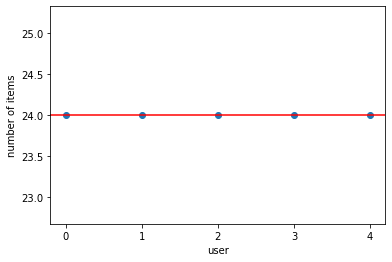

In [45]:
plt.scatter(items_by_user.user, items_by_user.item)
plt.axhline(y=items_by_user.item.mean(), color='r', linestyle='-')
plt.ylabel('number of items')
plt.xlabel('user')
plt.show()

In [46]:
# users by item

unique_items = dataset.item.unique()
users_by_item = dataset.groupby(['item'])["user"].count().reset_index()
users_by_item = users_by_item.sort_values(by=['user'], ascending=False)

print('max users by item: ', users_by_item.user.max())
list_of_max_items = users_by_item[users_by_item.user == users_by_item.user.max()].item.values
print(list_of_max_items)

print(dataset[dataset.item == list_of_max_items[0]])

print('min users by item: ', users_by_item.user.min())
print('mean users by item: ', users_by_item.user.mean())

max users by item:  5
['CHEBI_15366' 'CHEBI_15858' 'DOID_6132' 'DOID_0111245' 'CHEBI_82411'
 'CHEBI_8015' 'CHEBI_60193' 'CHEBI_50906' 'CHEBI_4883' 'CHEBI_42478'
 'CHEBI_37527' 'CHEBI_36976' 'CHEBI_36080' 'CHEBI_35225' 'CHEBI_33696'
 'CHEBI_32954' 'CHEBI_30089' 'CHEBI_29016' 'CHEBI_25367' 'CHEBI_24866'
 'CHEBI_17790' 'CHEBI_17562' 'CHEBI_16811' 'DOID_8771']
    user         item  rating    item_name  year
0      0  CHEBI_15366       1  acetic acid  2003
24     1  CHEBI_15366       1  acetic acid  2003
48     2  CHEBI_15366       1  acetic acid  2003
72     3  CHEBI_15366       1  acetic acid  2003
96     4  CHEBI_15366       1  acetic acid  2003
min users by item:  5
mean users by item:  5.0


In [47]:
dataset_doid = dataset[dataset.item.str.startswith('DOID')]
unique_items_d = dataset_doid.item.unique()
users_by_item_d = dataset_doid.groupby(['item'])["user"].count().reset_index()
users_by_item_d = users_by_item_d.sort_values(by=['user'], ascending=False)

print('max users by item: ', users_by_item_d.user.max())
list_of_max_items_d = users_by_item_d[users_by_item_d.user == users_by_item_d.user.max()].item.values
print(list_of_max_items_d)

print(dataset_doid[dataset_doid.item == list_of_max_items_d[0]])

print('min users by item: ', users_by_item_d.user.min())
print('mean users by item: ', users_by_item_d.user.mean())

max users by item:  5
['DOID_0111245' 'DOID_6132' 'DOID_8771']
     user          item  rating  \
21      0  DOID_0111245       1   
45      1  DOID_0111245       1   
69      2  DOID_0111245       1   
93      3  DOID_0111245       1   
117     4  DOID_0111245       1   

                                             item_name  year  
21   palmoplantar keratoderma and congenital alopec...  2003  
45   palmoplantar keratoderma and congenital alopec...  2003  
69   palmoplantar keratoderma and congenital alopec...  2003  
93   palmoplantar keratoderma and congenital alopec...  2003  
117  palmoplantar keratoderma and congenital alopec...  2003  
min users by item:  5
mean users by item:  5.0


In [48]:
dataset_chebi = dataset[dataset.item.str.startswith('CHEBI')]
unique_items_c = dataset_chebi.item.unique()
users_by_item_c = dataset_chebi.groupby(['item'])["user"].count().reset_index()
users_by_item_c = users_by_item_c.sort_values(by=['user'], ascending=False)

print('max users by item: ', users_by_item_c.user.max())
list_of_max_items_c = users_by_item_c[users_by_item_c.user == users_by_item_c.user.max()].item.values
print(list_of_max_items_c)

print(dataset_chebi[dataset_chebi.item == list_of_max_items_c[0]])

print('min users by item: ', users_by_item_c.user.min())
print('mean users by item: ', users_by_item_c.user.mean())

max users by item:  5
['CHEBI_15366' 'CHEBI_35225' 'CHEBI_8015' 'CHEBI_60193' 'CHEBI_50906'
 'CHEBI_4883' 'CHEBI_42478' 'CHEBI_37527' 'CHEBI_36976' 'CHEBI_36080'
 'CHEBI_33696' 'CHEBI_15858' 'CHEBI_32954' 'CHEBI_30089' 'CHEBI_29016'
 'CHEBI_25367' 'CHEBI_24866' 'CHEBI_17790' 'CHEBI_17562' 'CHEBI_16811'
 'CHEBI_82411']
    user         item  rating    item_name  year
0      0  CHEBI_15366       1  acetic acid  2003
24     1  CHEBI_15366       1  acetic acid  2003
48     2  CHEBI_15366       1  acetic acid  2003
72     3  CHEBI_15366       1  acetic acid  2003
96     4  CHEBI_15366       1  acetic acid  2003
min users by item:  5
mean users by item:  5.0


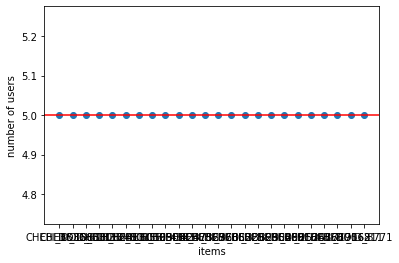

In [49]:
#%matplotlib qt

plt.scatter(users_by_item.item, users_by_item.user)
plt.axhline(y=users_by_item.user.mean(), color='r', linestyle='-')
#plt.yscale('log')
plt.ylabel('number of users')
plt.xlabel('items')
plt.show()